In [1]:
# # Install pandas
# !pip install pandas

# # Install scikit-learn
# !pip install scikit-learn

# # Install SHAP
# !pip install shap

# # Install LIME
# !pip install lime

# # Install matplotlib
# !pip install matplotlib

# # Install seaborn
# !pip install seaborn

# # Install TensorFlow
# !pip install tensorflow

In [2]:
#  Import the necessary liabraries  
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier  # Import the MLPClassifier

# SHAP and LIME library for explanability of the EPC label classifications
import shap  
import lime
import lime.lime_tabular


import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import re  # regular expressions


import seaborn as sns

# for deep explainer NN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam





# Load the data from the CSV excel file
file_path = 'Barcelona.csv' 
df = pd.read_csv(file_path)

 # allow pandas to display all columns
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 30)


# Display the first few rows of the Data Frame to understand the structure for data manipulation
print('columns',len(df.columns))
print('test')
print("First few rows of the data:")
print(df.head())


columns 30
test
First few rows of the data:
                ADREÇA  \
0      Ronda Catalunya   
1     Carrer Can Forns   
2       Carrer Puigmal   
3  Plaça DELS MERINALS   
4      Carrer Montsant   

  NOM_PROVINCIA  \
0     Barcelona   
1     Barcelona   
2     Barcelona   
3     Barcelona   
4     Barcelona   

   METRES_CADASTRE  \
0           120.60   
1           193.00   
2           154.00   
3            52.95   
4           106.00   

   Energia primària no renovable  \
0                          54.15   
1                          72.52   
2                          34.10   
3                         304.14   
4                          31.38   

  Qualificacio d'emissions de CO2  \
0                               B   
1                               B   
2                               A   
3                               F   
4                               A   

   Emissions de CO2  \
0             11.20   
1             14.68   
2              6.19   
3             57.16

## Data Prepreprocessing

In [3]:
# Get the shape of the DataFrame
print("Shape of the DataFrame:", df.shape) ## rows vs columns

# Check data types of each column
print("Data types of each column:")
print(df.dtypes)

print("Number of columns:", len(df.columns))


Shape of the DataFrame: (957126, 30)
Data types of each column:
ADREÇA                                                     object
NOM_PROVINCIA                                              object
METRES_CADASTRE                                           float64
Energia primària no renovable                             float64
Qualificacio d'emissions de CO2                            object
Emissions de CO2                                          float64
Consum d'energia final                                    float64
Cost anual aproximat d'energia per habitatge              float64
VALOR AILLAMENTS                                          float64
VALOR FINESTRES                                           float64
VALOR AILLAMENTS CTE                                      float64
VALOR FINESTRES CTE                                       float64
Qualificació emissions calefacció                          object
Emissions calefacció                                      float64
Qualificació

In [4]:
# Check for missing values in each column
missing_values = df.isnull().sum() 
print("Missing values in each column:")
print(missing_values.to_list()) #convert the totals numbers to a list


Missing values in each column:
[0, 0, 0, 151, 0, 197, 32174, 32174, 32174, 32174, 0, 0, 78451, 75203, 111484, 75205, 98353, 75203, 78420, 75204, 111477, 75292, 97727, 75204, 77803, 75202, 111300, 75255, 0, 0]


In [5]:
# Get summary statistics for numerical columns
print("Summary statistics for numerical columns:")
print(df.describe())

Summary statistics for numerical columns:
       METRES_CADASTRE  \
count    957126.000000   
mean        142.472573   
std         925.278040   
min           0.170000   
25%          57.000000   
50%          72.000000   
75%          99.000000   
max      357792.000000   

       Energia primària no renovable  \
count                  956975.000000   
mean                      204.290356   
std                       291.974997   
min                       -48.210000   
25%                       140.655000   
50%                       187.170000   
75%                       243.730000   
max                     96535.080000   

       Emissions de CO2  \
count     956929.000000   
mean          43.770218   
std          220.702190   
min           -8.170000   
25%           29.140000   
50%           38.940000   
75%           50.780000   
max        98346.000000   

       Consum d'energia final  \
count           924952.000000   
mean               121.131311   
std                

In [6]:
# Print the names of the columns
print("Column names:", df.columns.tolist())

Column names: ['ADREÇA', 'NOM_PROVINCIA', 'METRES_CADASTRE', 'Energia primària no renovable', "Qualificacio d'emissions de CO2", 'Emissions de CO2', "Consum d'energia final", "Cost anual aproximat d'energia per habitatge", 'VALOR AILLAMENTS', 'VALOR FINESTRES', 'VALOR AILLAMENTS CTE', 'VALOR FINESTRES CTE', 'Qualificació emissions calefacció', 'Emissions calefacció', 'Qualificació emissions refrigeració', 'Emissions refrigeració', 'Qualificació emissions ACS', 'Emissions ACS', 'Qualificació energia calefacció', 'Energia calefacció', 'Qualificació energia refrigeració', 'Energia refrigeració', 'Qualificació energia ACS', 'Energia ACS', 'Qualificació energia calefacció demanda', 'Energia calefacció demanda', 'Qualificació energia refrigeració demanda', 'Energia refrigeració demanda', 'DATA_ENTRADA', "Qualificació de consum d'energia primaria no renovable"]


In [7]:
# Defined a dictionary with old names as keys and new names as values
rename_dict = {
    "METRES_CADASTRE": "Property Size (m²)",
    "Emissions de CO2": "CO2 Emissions (kg CO2/m²·year)",
    "Emissions calefacció": "Heating Emissions (kg CO2/m²·year)",
    "Emissions refrigeració": "Cooling Emissions (kg CO2/m²·year)",
    "Emissions ACS": "DHW Emissions (kg CO2/m²·year)",
    "Energia calefacció": "Heating Energy (kWh/m²·year)",
    "Energia refrigeració": "Cooling Energy (kWh/m²·year)",
    "Energia calefacció demanda": "Heating Demand Energy (kWh/m²·year)",
    "Energia refrigeració demanda": "Cooling Demand Energy (kWh/m²·year)",
    "Qualificació de consum d'energia primaria no renovable": "Energy Performance Classification",
    "VALOR AILLAMENTS": "Average Facade Transmittance (W/m²·K)",
    "VALOR FINESTRES": "Average Window Transmittance (W/m²·K)",
    "VALOR AILLAMENTS CTE": "Max Facade Transmittance (CTE) (W/m²·K)",
    "VALOR FINESTRES CTE": "Max Window Transmittance (CTE) (W/m²·K)",
    "Consum d'energia primària no renovable per al servei d'ACS": "Non-Renewable Energy for DHW (kWh/m²·year)",
    "Consum d'energia primària no renovable per al servei d'il·luminació": "Non-Renewable Energy for Lighting (kWh/m²·year)",
}

# Rename the columns in the DataFrame
df.rename(columns=rename_dict, inplace=True)

# Now df has the new column names, which will be used in all further operations
print("Column names:", df.columns.tolist())

Column names: ['ADREÇA', 'NOM_PROVINCIA', 'Property Size (m²)', 'Energia primària no renovable', "Qualificacio d'emissions de CO2", 'CO2 Emissions (kg CO2/m²·year)', "Consum d'energia final", "Cost anual aproximat d'energia per habitatge", 'Average Facade Transmittance (W/m²·K)', 'Average Window Transmittance (W/m²·K)', 'Max Facade Transmittance (CTE) (W/m²·K)', 'Max Window Transmittance (CTE) (W/m²·K)', 'Qualificació emissions calefacció', 'Heating Emissions (kg CO2/m²·year)', 'Qualificació emissions refrigeració', 'Cooling Emissions (kg CO2/m²·year)', 'Qualificació emissions ACS', 'DHW Emissions (kg CO2/m²·year)', 'Qualificació energia calefacció', 'Heating Energy (kWh/m²·year)', 'Qualificació energia refrigeració', 'Cooling Energy (kWh/m²·year)', 'Qualificació energia ACS', 'Energia ACS', 'Qualificació energia calefacció demanda', 'Heating Demand Energy (kWh/m²·year)', 'Qualificació energia refrigeració demanda', 'Cooling Demand Energy (kWh/m²·year)', 'DATA_ENTRADA', 'Energy Perform

In [8]:
selected_feature_name = ["Property Size (m²)", "CO2 Emissions (kg CO2/m²·year)", "Heating Emissions (kg CO2/m²·year)","Cooling Emissions (kg CO2/m²·year)", "DHW Emissions (kg CO2/m²·year)", "Heating Demand Energy (kWh/m²·year)", "Cooling Demand Energy (kWh/m²·year)", "Average Facade Transmittance (W/m²·K)", "Average Window Transmittance (W/m²·K)"]  # List of new feature names
target_feature_name = ["Energy Performance Classification"]   # Ensure this is not included in selected_feature_names

In [9]:
# remove rows that contains columns with missing data
features = selected_feature_name + target_feature_name
selected_df= df[features]
selected_df = selected_df.dropna()

selected_df.describe()

,Property Size (m²),CO2 Emissions (kg CO2/m²·year),Heating Emissions (kg CO2/m²·year),Cooling Emissions (kg CO2/m²·year),DHW Emissions (kg CO2/m²·year),Heating Demand Energy (kWh/m²·year),Cooling Demand Energy (kWh/m²·year),Average Facade Transmittance (W/m²·K),Average Window Transmittance (W/m²·K)
count,852700.000000,852700.000000,852700.000000,852700.000000,852700.000000,852700.000000,852700.000000,852700.000000,8.527000e+05
mean,143.334671,42.753077,28.587572,1.245178,9.757477,96.086551,6.761635,1.546956,1.919824e+05
std,952.821305,150.955455,17.170640,1.866165,19.777475,46.147536,8.512891,0.759678,4.377329e+06
min,1.000000,-8.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,57.000000,29.100000,18.050000,0.520000,5.130000,65.730000,2.970000,0.820000,3.470000e+00
50%,72.000000,38.740000,25.810000,0.910000,8.610000,89.510000,5.160000,1.690000,3.870000e+00
75%,100.000000,50.240000,35.790000,1.470000,12.910000,119.740000,8.060000,2.090000,5.000000e+00
max,357792.000000,98346.000000,2208.020000,582.420000,12222.720000,3622.300000,1573.100000,5.880000,1.000000e+08


In [10]:
input_features = selected_df[selected_feature_name]
output_classification = selected_df[target_feature_name]

print('input_features',input_features)
print('output_classification',output_classification)

input_features         Property Size (m²)  \
0                   120.60   
1                   193.00   
2                   154.00   
3                    52.95   
4                   106.00   
...                    ...   
957121               61.00   
957122               45.00   
957123               87.00   
957124               98.00   
957125              140.00   

        CO2 Emissions (kg CO2/m²·year)  \
0                                11.20   
1                                14.68   
2                                 6.19   
3                                57.16   
4                                 5.45   
...                                ...   
957121                           28.89   
957122                           17.18   
957123                           39.83   
957124                           48.13   
957125                           44.02   

        Heating Emissions (kg CO2/m²·year)  \
0                                     6.35   
1                          

In [11]:
sampled_df = selected_df.sample(frac=0.8, random_state=0)  # 80% of the rows




# Prepare the features and EPC target from the sampled data
X = sampled_df[selected_feature_name]
y = sampled_df[target_feature_name]



## Initialize and Fit the ANN Model

In [12]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize the ANN model with a smaller architecture for quicker computation
ann_classifier = MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, activation='relu', solver='adam', random_state=1)

# Fit the model
ann_classifier.fit(X_train, y_train)

### Evaluate the Model
y_pred = ann_classifier.predict(X_test) # Predicting the test set results
#y_pred = ann_classifier.predict(X_test)

# Generating and outputting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)




C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
[[ 1107   110    96    13    67     0     6]
 [  465   618   581   209   233    14    25]
 [   42   332  2729  1408  1331    99   268]
 [   22    42  1291  6443  4283   181   581]
 [   14    21   548  2187 62863  2393  2281]
 [    8     2    72   230  6209  6777  3964]
 [    9     4    19    90  2501  2241 21403]]


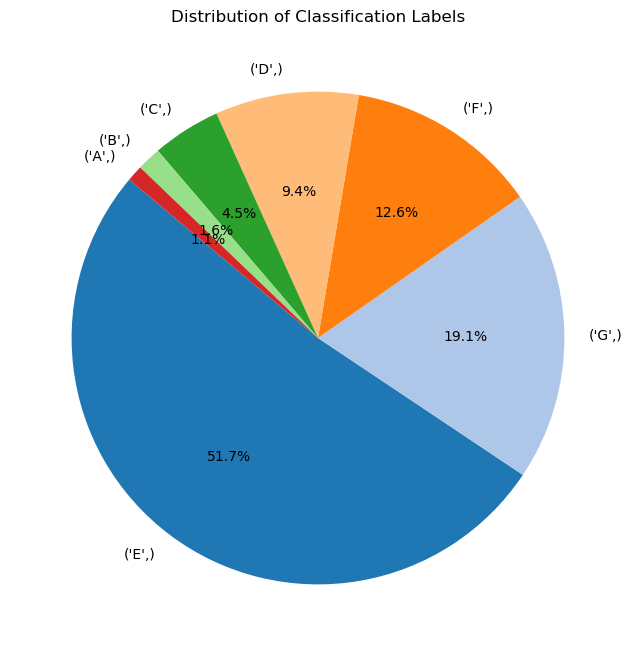

In [13]:
#  'Energy Performance Classification' is the column with the target labels
label_counts = sampled_df[target_feature_name].value_counts()

# Generate the pie chart
plt.figure(figsize=(10, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Distribution of Classification Labels')
plt.show()

C:\Users\u18352805\AppData\Local\Temp\ipykernel_5128\1526471307.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ann_classifier.classes_.tolist())
C:\Users\u18352805\AppData\Local\Temp\ipykernel_5128\1526471307.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ann_classifier.classes_.tolist())


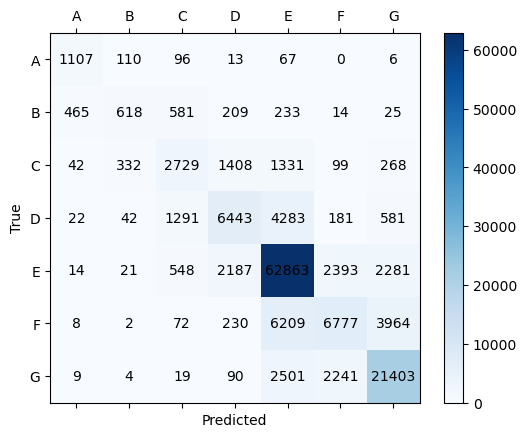

In [14]:
###  better Visualize the Confusion Matrix

# Visualize the confusion matrix in a more interpretable format
fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)

# fill the matrix with text in each cell
for (i, j), val in np.ndenumerate(conf_matrix):
    ax.text(j, i, f'{val}', ha='center', va='center', color='black')

# Set labels based on the classifier's classes, ensuring labels are displayed correctly
ax.set_xticklabels([''] + ann_classifier.classes_.tolist())
ax.set_yticklabels([''] + ann_classifier.classes_.tolist())
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_

C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_

C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_

C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_

C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_

C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_

Epoch 150/150, Train Accuracy: 0.7475, Validation Accuracy: 0.7480


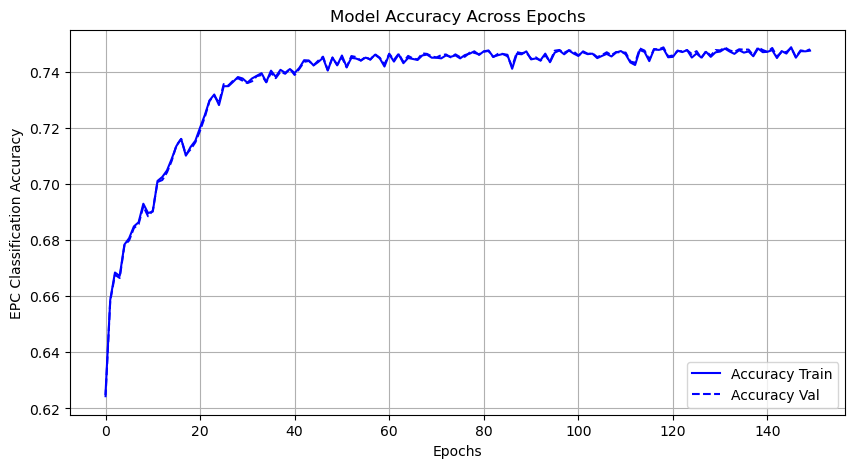

In [15]:
# Initialize the ANN model
hidden_layer_sizes = (60,)
max_iter = 300  
ann_classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter,
                               activation='relu', solver='adam', random_state=0, warm_start=True)

# Lists to store accuracies
train_accuracies = []
val_accuracies = []

# Define the number of epochs
epochs = 150

for epoch in range(epochs):
    ann_classifier.partial_fit(X_train, y_train, classes=np.unique(y_train))  # Fit the model incrementally
    train_pred = ann_classifier.predict(X_train)
    val_pred = ann_classifier.predict(X_test)

    # Compute training and validation accuracy
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_test, val_pred)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Only print the output at the final iteration
    if epoch == epochs - 1:
        print(f'Epoch {epoch+1}/{epochs}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

### Plot Training and Validation Accuracies

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Accuracy Train', linestyle='-', marker='', color='blue')
plt.plot(val_accuracies, label='Accuracy Val', linestyle='--', marker='', color='blue')
plt.title('Model Accuracy Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('EPC Classification Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [16]:
# explainer = lime.lime_tabular.LimeTabularExplainer(
#     training_data=X_train.values,
#     feature_names=X,
#     class_names=np.unique(y).tolist(),
#     mode='classification'
# )

# # Select instance
# predicted_class = 'E'
# indices = [i for i, x in enumerate(y_test.values) if x[0] == predicted_class]
# if not indices:
#     raise ValueError("No instance with class E found in the test set.")
# index_to_explain = indices[0]

# instance = X_test.iloc[index_to_explain].values

# # Generate LIME explanation
# explanation = explainer.explain_instance(
#     data_row=instance,
#     predict_fn=ann_classifier.predict_proba
# )
# # Display the explanation

# explanation.show_in_notebook(show_all=False)

# # Assuming 'explanation' is already generated
# exp_list = explanation.as_list()

# # Sorting the explanation list by the absolute contribution values
# exp_list_sorted = sorted(exp_list, key=lambda x: abs(x[1]), reverse=True)

# # Separating feature names and their contributions
# features, scores = zip(*exp_list_sorted)
# colors = ['orange' if x > 0 else 'skyblue' for x in scores]

# plt.figure(figsize=(18, 16))
# bars = plt.barh(features, scores, color=colors)
# plt.xlabel('Feature Contribution')
# plt.title('LIME Explanation - Feature Importance')
# plt.axvline(x=0, color='grey', linewidth=0.8)

# # Adding text labels
# for bar, value in zip(bars, scores):
#     plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
#              f'{value:.3f}', 
#              va='center', ha='right' if value < 0 else 'left')

# plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
# plt.show()

C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


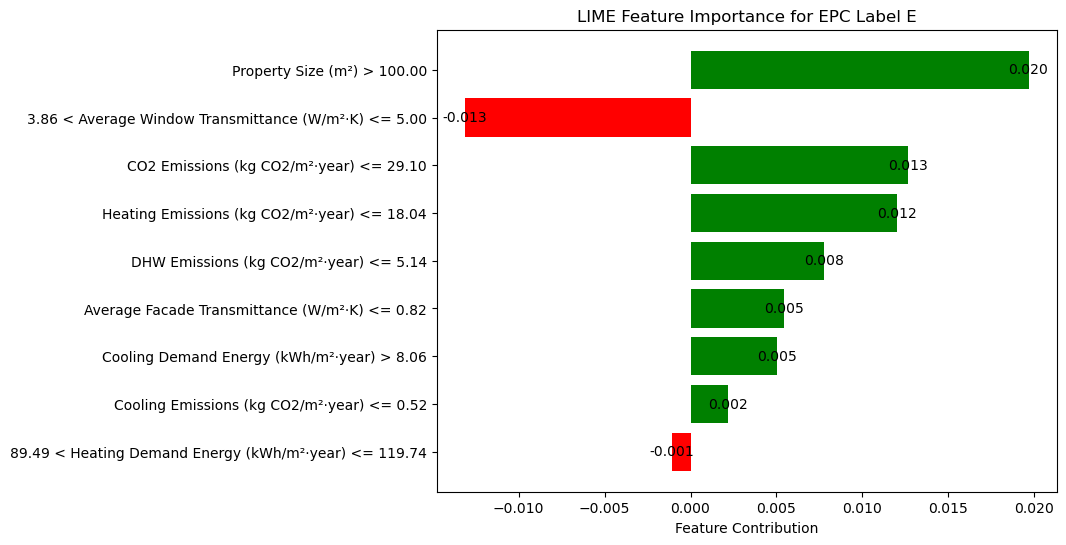

In [32]:
# # X = sampled_df[selected_feature_name]
# # y = sampled_df[target_feature_name]





# Initialize the classifier
ann_classifier = MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, activation='relu', solver='adam', random_state=0)
ann_classifier.fit(X_train, y_train)

# Define a prediction function that is compatible with LIME
def model_predict_proba(data):
    return ann_classifier.predict_proba(data)

# Initialize the LIME Explainer
# explainer = LimeTabularExplainer(
#     training_data=X_train.values,
#     feature_names=X_train.columns.tolist(),
#     class_names=np.unique(y_train).tolist(),
#     mode='classification'
# )


explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X,
    class_names=np.unique(y).tolist(),
    mode='classification'
)


predicted_class = 'A'
indices = [i for i, x in enumerate(y_test.values) if x[0] == predicted_class]
if not indices:
    raise ValueError("No instance with class E found in the test set.")
index_to_explain = indices[0]


instance = X_test.iloc[index_to_explain].values # Instance for explanation

# Generate LIME explanation
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=np.unique(y_train).tolist(),
    mode='classification'
)

explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=ann_classifier.predict_proba,
    labels=[list(np.unique(y_train)).index(predicted_class)]  # ensure the label index is correct
)

# Get the explanation data for the specific class
exp = explanation.as_list(label=list(np.unique(y_train)).index(predicted_class))

# Sort the features by their impact
exp_sorted = sorted(exp, key=lambda x: -abs(x[1]))

# Display the explanation

explanation.show_in_notebook(show_all=False)

# Plot
plt.figure(figsize=(8, 6))
bar_positions = np.arange(len(exp_sorted))
bar_values = [x[1] for x in exp_sorted]
bar_labels = [x[0] for x in exp_sorted]
colors = ['green' if x[1] > 0 else 'red' for x in exp_sorted]

bars = plt.barh(bar_positions, bar_values, align='center', color=colors)
plt.yticks(bar_positions, bar_labels)
plt.xlabel('Feature Contribution')
plt.title('LIME Feature Importance for EPC Label E')


for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, # Adding the value next to each bar
             f'{width:.3f}', 
             ha='center', va='center')

plt.gca().invert_yaxis()  # Invert y axis to have the most important feature at the top
plt.show()



In [18]:
# # Assuming 'explanation' is your LIME explanation object for a specific instance
# # And assuming the internal label for 'E' is determined (let's say it is 4, you need to adjust this according to your model)
# label_for_E = 1

# # Get the explanation for the specific label
# explanation_for_E = explanation.as_list(label=label_for_E)

# # Sort the features by their effect size
# sorted_features = sorted(explanation_for_E, key=lambda x: x[1], reverse=True)

# # Split the feature names and their weights
# feature_names, feature_scores = zip(*sorted_features)

# # Generate colors based on the contribution positive (green) or negative (red)
# colors = ['green' if score > 0 else 'red' for score in feature_scores]

# # Create the plot
# plt.figure(figsize=(1, 8))
# bars = plt.barh(feature_names, feature_scores, color=colors)
# plt.xlabel('Feature Contribution')
# plt.title('Feature Importance for EPC Label E (LIME)')

# # Adding the value next to each bar for clarity
# for bar, value in zip(bars, feature_scores):
#     plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
#              f'{value:.3f}', 
#              va='center', ha='right' if value < 0 else 'left', color='black')

# plt.gca().invert_yaxis()  # Display the most important feature at the top
# plt.show()


In [19]:


# print("Available classes in the explanation:", explanation.available_labels())
# label_for_E = 'E'  # Adjust this as necessary based on the output above
# try:
#     feature_names = explanation.as_list(label=label_for_E)
# except KeyError:
#     print(f"No explanation for label {label_for_E}.")
#     feature_names = []

# # Proceed only if feature names were successfully retrieved
# if feature_names:
#     # Sorting features by their importance
#     sorted_features = sorted(feature_names, key=lambda x: x[1], reverse=True)

#     # Separating names and scores for easier plotting
#     names = [feat[0] for feat in sorted_features]
#     scores = [feat[1] for feat in sorted_features]

#     # Creating the plot
#     plt.figure(figsize=(10, 8))
#     colors = ['green' if x > 0 else 'red' for x in scores]
#     bars = plt.barh(names, scores, color=colors)
#     plt.xlabel('LIME Feature Importance')
#     plt.title('LIME Feature Importance for EPC Label E')

#     # Adding the value next to each bar
#     for bar, value in zip(bars, scores):
#         plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
#                  f'{value:.2f}', 
#                  va='center', color='black' if abs(value) > 0.1 else 'white')

#     plt.gca().invert_yaxis()  # To display the highest importance at the top
#     plt.show()
# else:
#     print("No feature importances to display.")


In [20]:
#####################computation time is too long 
# # Split data
# features = sampled_df[selected_feature_name]
# target = sampled_df[target_feature_name]
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # Train the model
# model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=150, activation='relu', solver='adam', random_state=1)
# model.fit(X_train, y_train)

# # Initialize SHAP Explainer
# explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, 100))  # Using 100 samples for speed

# # Compute SHAP Values for the test set
# shap_values = explainer.shap_values(X_test)

# # Filter for instances classified as 'E'
# predicted_E = model.predict(X_test) == 'E'
# X_test_E = X_test[predicted_E]
# shap_values_E = explainer.shap_values(X_test_E)

# # Visualize the SHAP values for 'E' classification
# shap.summary_plot(shap_values_E, X_test_E, feature_names=X_test.columns)

In [21]:
!pip install tensorflow


In [22]:
#############TAKES LONG TO COMPUTE

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # Train the model
# model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, activation='relu', solver='adam', random_state=1)
# model.fit(X_train, y_train)

# # Use K-Means to summarize the training data for SHAP
# background_data = shap.kmeans(X_train, 10)  # Summarize with 10 centroids

# # Initialize SHAP KernelExplainer using the K-Means summary
# explainer = shap.KernelExplainer(model.predict_proba, background_data)

# # Compute SHAP Values for the test set (might still be computationally intensive depending on the test set size)
# shap_values = explainer.shap_values(X_test)

# # Filter for instances predicted as 'E'
# predictions = model.predict(X_test)
# predicted_E = predictions == 'E'
# X_test_E = X_test[predicted_E]

# if any(predicted_E):
#     shap_values_E = explainer.shap_values(X_test_E)

#     # Visualize the SHAP values for 'E' classification
#     shap.summary_plot(shap_values_E, X_test_E, feature_names=X_test.columns)
# else:
#     print("No instances of 'E' were predicted in the test set.")

In [23]:
# # Define a function that returns the probability predictions from the model
# def model_proba(data):
#     return model.predict_proba(data)

# # Using a smaller background dataset to speed up computation
# background = shap.sample(X_train, 50)  # Reducing the sample size from 100 to 50

# # Initialize the SHAP KernelExplainer with the wrapper function
# explainer = shap.KernelExplainer(model_proba, background)

# # Calculate SHAP values in batches
# batch_size = 50  # Adjust based on your system's memory and performance characteristics
# shap_values = []
# for start in range(0, len(X_train), batch_size):
#     batch = X_train.iloc[start:start+batch_size]
#     batch_shap_values = explainer.shap_values(batch)
#     shap_values.append(batch_shap_values)

# # Concatenate the batch results
# shap_values = np.concatenate(shap_values, axis=1)

# # Assuming the index of class 'E' is known (e.g., index 1)
# mean_shap_values = np.mean(shap_values[1], axis=0)  # Adjust the class index as necessary

# # Plot the mean SHAP values
# shap.summary_plot(mean_shap_values, X_train.columns, plot_type="bar")

In [24]:

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y) # Encode the target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define and train the model
model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, activation='relu', solver='adam', random_state=1)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


C:\Users\u18352805\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7400463234431804


In [25]:
# # Convert MLPClassifier to Keras model
# input_dim = X_train.shape[1]
# output_dim = len(np.unique(y_train))

# model = Sequential()
# model.add(Input(shape=(input_dim,)))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(output_dim, activation='softmax'))

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Convert target labels to one-hot encoded vectors
# y_train_one_hot = to_categorical(LabelEncoder().fit_transform(y_train))
# y_test_one_hot = to_categorical(LabelEncoder().fit_transform(y_test))

# # Train the Keras model
# model.fit(X_train, y_train_one_hot, epochs=150, batch_size=32, verbose=0)

# # Select the instance to explain
# predicted_class = 'G'
# indices = [i for i, x in enumerate(y_test) if x == predicted_class]
# if not indices:
#     raise ValueError("No instance with class G found in the test set.")
# index_to_explain = indices[0]

# instance = X_test.iloc[index_to_explain].values.reshape(1, -1)

# # Create a DeepExplainer object
# explainer = shap.DeepExplainer(model, X_train)

# # Generate SHAP values for the instance
# shap_values = explainer.shap_values(instance)

# # Get the class index for the predicted class
# class_index = list(model.predict(instance).argmax(axis=1))

# # Plot the SHAP values for the predicted class
# shap.summary_plot(shap_values[class_index[0]], instance, feature_names=X_train.columns, plot_type='bar', max_display=len(X_train.columns))

In [26]:
# # Convert the sklearn model to a Keras model for compatibility with DeepExplainer
# # def build_model(input_dim, output_dim):
# #     keras_model = Sequential([
# #         Dense(50, input_dim=input_dim, activation='relu'),
# #         Dense(output_dim, activation='softmax')
# #     ])
# #     keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# #     return keras_model

# #keras_model = build_model(X_train.shape[1], len(np.unique(y_encoded)))

# #keras_model.fit(X_train, y_train, epochs=10, verbose=0)  # Train Keras model


# # Use DeepExplainer
# background = X_train.iloc[:100].astype(np.float32).values  # Background dataset for SHAP
# explainer = shap.DeepExplainer(model, background)
# shap_values = explainer.shap_values(X_test.iloc[:100].astype(np.float32))

# # Visualize SHAP values for the class corresponding to label 'G'
# g_class_index = encoder.transform(['G'])[0]  # Assuming 'G' is a class in your target
# shap.summary_plot(shap_values[g_class_index], X_test.iloc[:100], plot_type="bar")

In [27]:
################################################################################

In [28]:
############### Shapley #######################



In [29]:
##### speed up SHAP #############################################################

# Sample data for initial testing and analysis
df_sample = selected_df.sample(frac=0.1, random_state=0)  # Adjust fraction as needed based on computational resources

input_features = X
output_classification = y

# Splitting and training
X_train, X_test, y_train, y_test = train_test_split(input_features, output_classification, test_size=0.2, random_state=0)
dt_classifier = DecisionTreeClassifier(max_depth=3, random_state=0)  # Limit the depth of the tree
dt_classifier.fit(X_train, y_train)

# Predicting and evaluating
y_pred = dt_classifier.predict(X_test)


# Check class names and their indices
class_names = dt_classifier.classes_
print("Classes predicted by the model:", class_names)

if 'G' in class_names:
    g_index = list(class_names).index('G')
    print("Index for class 'G':", g_index)
else:
    print("Class 'G' not found in the model's classes.")

Classes predicted by the model: ['A' 'B' 'C' 'D' 'E' 'F' 'G']
Index for class 'G': 6


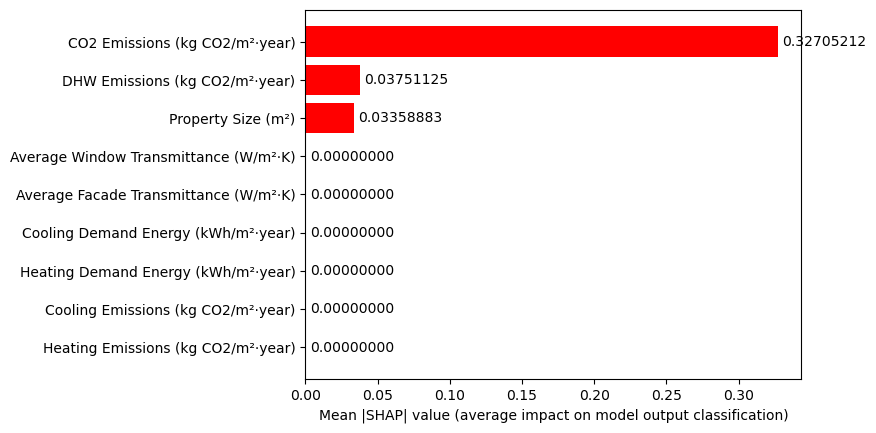

In [30]:
# Initialize the SHAP Explainer
explainer = shap.TreeExplainer(dt_classifier)

# Compute SHAP values for a sample of the training set
shap_sample = X_train.sample(485269, random_state=0)  # Sample size adjusted for computational efficiency 
shap_values = explainer.shap_values(shap_sample)


shap_values_index = shap_values[:, :, 4]  # Extract SHAP values for class 'E' across all samples. the SHAP values have the format (100, 9, 7)

# Calculate the mean SHAP values for each feature
mean_shap = np.abs(shap_values_index).mean(axis=0)

# Sort the features by mean SHAP value
sorted_indices = np.argsort(mean_shap)
sorted_feature_names = np.array(selected_feature_name)[sorted_indices]
sorted_mean_shap = mean_shap[sorted_indices]

# Create the plot manually
#plt.figure(figsize=(12, 8))
fig, ax = plt.subplots()
bars = ax.barh(sorted_feature_names, sorted_mean_shap, color='red')
ax.set_xlabel('Mean |SHAP| value (average impact on model output classification)')

# Adding mean SHAP values as annotations next to the bars
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + max(mean_shap) * 0.01  # Offset label to the right of the bar
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.8f}', va='center')

plt.show()
